In [1]:
import os
from pylab import rcParams
import math
rcParams['figure.figsize'] = 10,6
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product
from tqdm import tqdm_notebook
%matplotlib inline
import matplotlib
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y')
df = pd.read_csv('Tesla_stock_price.csv', index_col='Date', parse_dates=['Date'], date_parser=dateparse, sep=',').fillna(0)

In [3]:
df

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
...,...,...,...,...,...,...
2017-03-13,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
2017-03-14,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
2017-03-15,257.000000,261.000000,254.270004,255.729996,4816600,255.729996


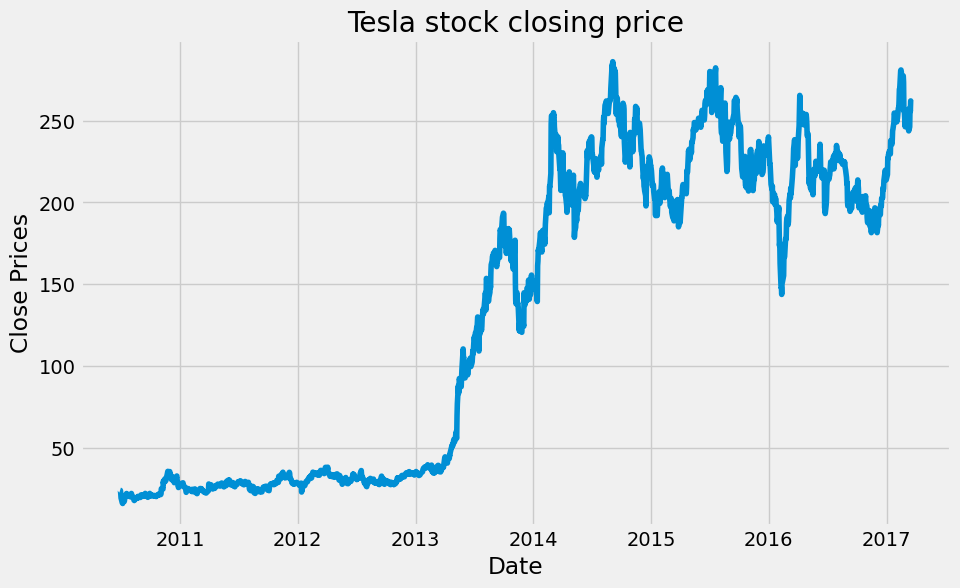

In [4]:
plt.figure(figsize = (10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('Tesla stock closing price')
plt.show()

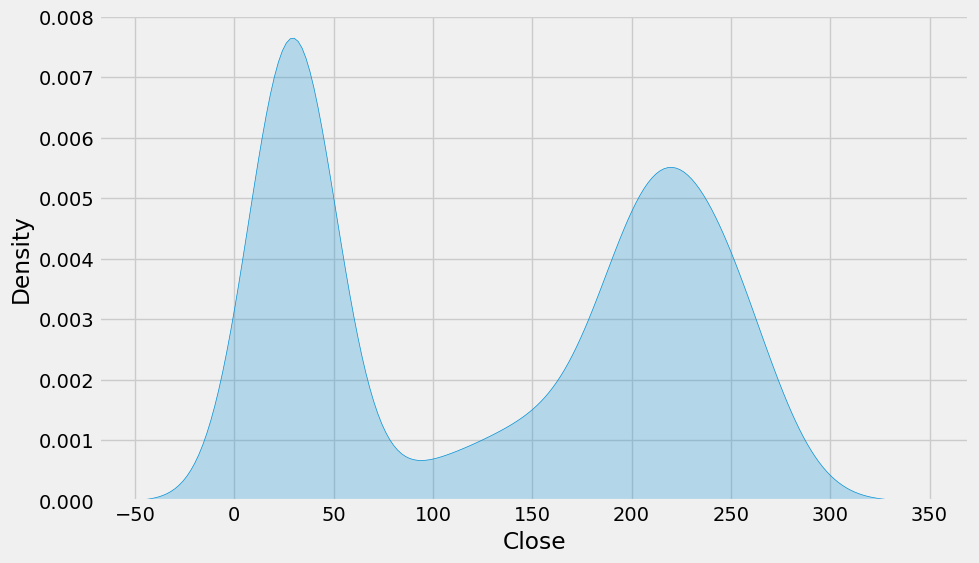

In [5]:
column_name = 'Close'
sns.kdeplot(data = df[column_name], fill = True)
plt.show()

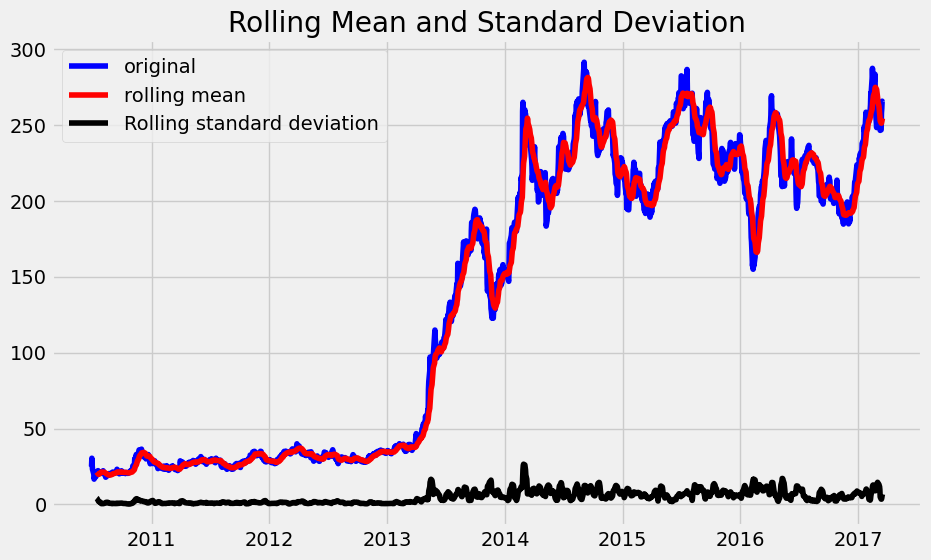

Result of Dickey Fuller test: 
Test Statistics               -0.819457
p-value                        0.813340
No. of lags used               6.000000
No. of observations used    1685.000000
Critical value(1%)            -3.434237
Critical value(5%)            -2.863257
Critical value(10%)           -2.567684
dtype: float64


In [6]:
def stationarity_test(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries,color = 'blue', label = 'original')
    plt.plot(rolmean,color = 'red',label = 'rolling mean')
    plt.plot(rolstd, color = 'black', label = 'Rolling standard deviation')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block = False)
    print('Result of Dickey Fuller test: ')
    adft = adfuller(timeseries, autolag = 'AIC')
    output = pd.Series(adft[0:4],index = ['Test Statistics','p-value','No. of lags used', 'No. of observations used'])
    for key,values in adft[4].items():
        output['Critical value(%s)'%key] = values
    print(output)
column_name = 'High'
stationarity_test(df[column_name])

In [7]:
df_close = pd.read_csv('Tesla_stock_price.csv', usecols = ['Close'])

In [8]:
df_close

,Close
0,23.889999
1,23.830000
2,21.959999
3,19.200001
4,16.110001
...,...
1687,246.169998
1688,258.000000
1689,255.729996
1690,262.049988


<Figure size 1000x600 with 0 Axes>

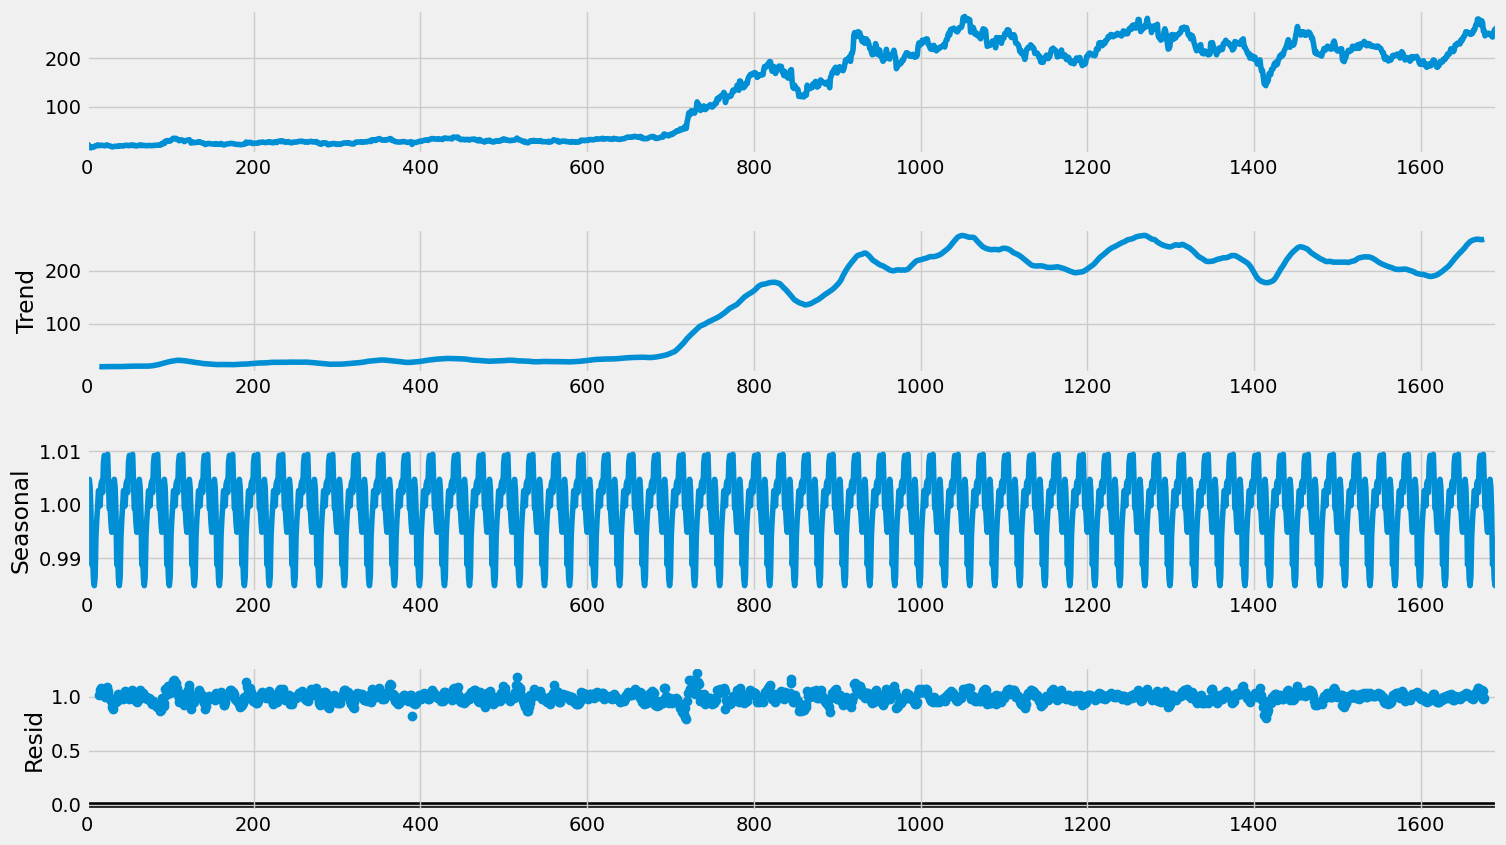

In [9]:
result = seasonal_decompose(df_close, model = 'multiplicative', period = 30)
fig  = plt.figure()
fig = result.plot()
fig.set_size_inches(16,9)
plt.show()

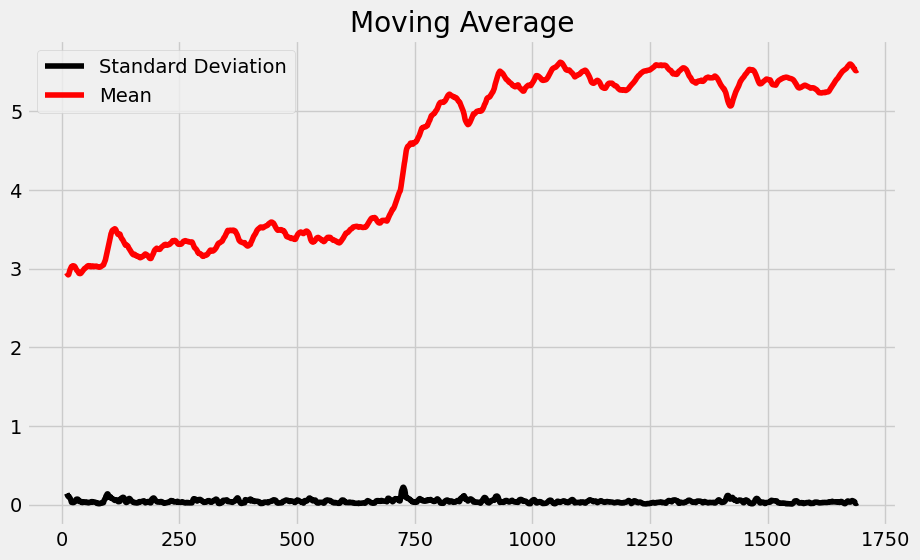

In [10]:
rcParams['figure.figsize'] = 10,6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.title('Moving Average')
plt.plot(std_dev, color = 'black', label = 'Standard Deviation')
plt.plot(moving_avg, color = 'red', label = 'Mean')
plt.legend(loc = 'best')
plt.show()

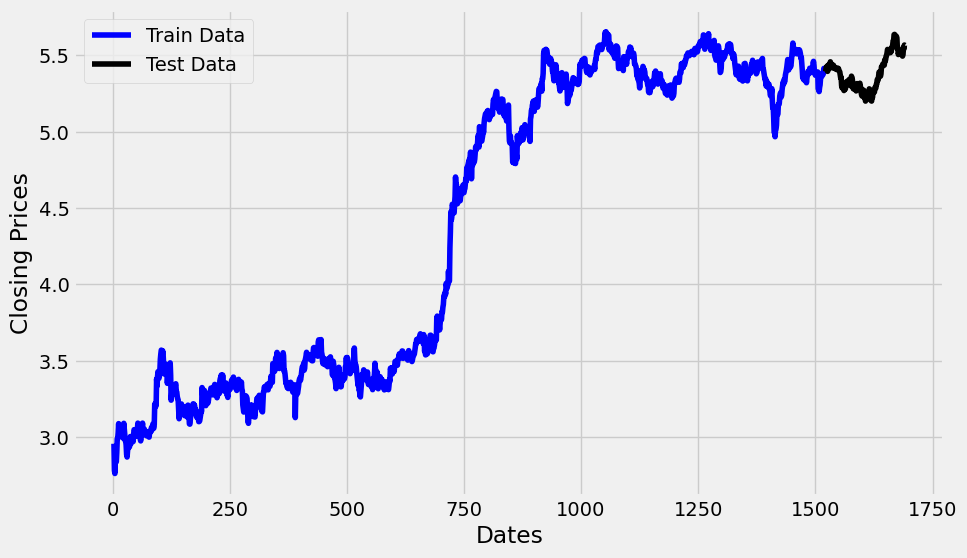

In [41]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize =(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, color = 'b', label = 'Train Data')
plt.plot(test_data, color = 'black', label = 'Test Data')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8879.728, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.87 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5971.513, Time=1.29 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.92 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5972.581, Time=1.60 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4839.350, Time=0.60 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.71 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-5970.628, Time=1.89 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3183.581, Time=0.80 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=3.34 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-5972.199, Time=1.77 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 16.185 seconds
                               SARIMAX Results                                
Dep. Variable:               

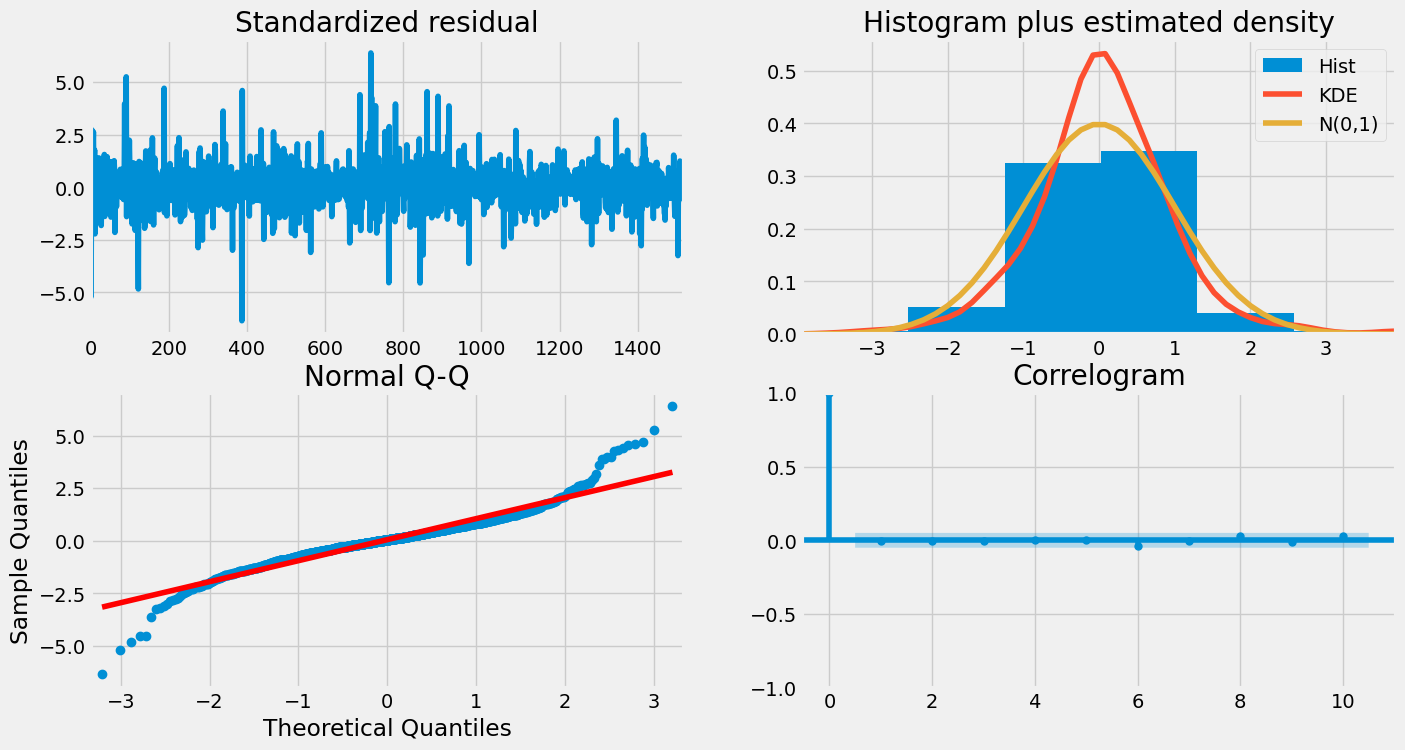

In [51]:
MODEL_ARIMA = auto_arima(train_data,start_p = 0, start_q = 0, test = 'adf', max_p = 5, max_q = 5, m = 1, d = 0, seasonal = False, start_P = 0, D = 0, trace = True, error_action = 'ignore', supress_warning = True, stepwise = True)
print(MODEL_ARIMA.summary())
MODEL_ARIMA.plot_diagnostics(figsize=(15, 8))
plt.show()

In [52]:
model = ARIMA(train_data, order = (1,0,2))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1519
Model:                 ARIMA(1, 0, 2)   Log Likelihood                2991.161
Date:                Mon, 31 Jul 2023   AIC                          -5972.323
Time:                        16:56:27   BIC                          -5945.694
Sample:                             0   HQIC                         -5962.409
                               - 1519                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3841      0.532      8.237      0.000       3.341       5.427
ar.L1          0.9990      0.001   1182.237      0.000       0.997       1.001
ma.L1          0.0042      0.018      0.230      0.8

In [70]:
forecast_results = fitted.get_forecast(steps=len(test_data), alpha=0.05)
forecast = forecast_results.predicted_mean
se = forecast_results.se_mean
conf_int = forecast_results.conf_int()
print("Forecasted Values:")
print(forecast)
print("\nStandard Errors:")
print(se)
print("\nPrediction Intervals:")
print(conf_int)

Forecasted Values:
1522    5.399840
1523    5.398992
1524    5.397997
1525    5.397003
1526    5.396011
          ...   
1687    5.248213
1688    5.247366
1689    5.246520
1690    5.245675
1691    5.244830
Name: predicted_mean, Length: 170, dtype: float64

Standard Errors:
1522    0.033699
1523    0.047735
1524    0.057657
1525    0.066091
1526    0.073550
          ...   
1687    0.386095
1688    0.387076
1689    0.388052
1690    0.389024
1691    0.389991
Name: var_pred_mean, Length: 170, dtype: float64

Prediction Intervals:
      lower Close  upper Close
1522     5.333791     5.465890
1523     5.305433     5.492551
1524     5.284991     5.511003
1525     5.267468     5.526539
1526     5.251855     5.540166
...           ...          ...
1687     4.491480     6.004946
1688     4.488711     6.006021
1689     4.485952     6.007088
1690     4.483202     6.008147
1691     4.480462     6.009199

[170 rows x 2 columns]


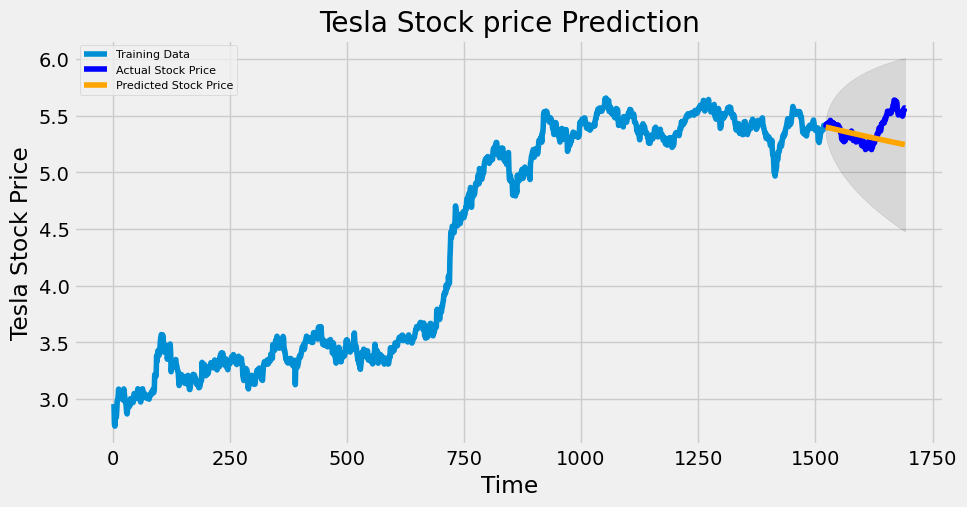

In [71]:
fc_series = pd.Series(forecast, index = test_data.index)
lower_series = pd.Series(conf_int["lower Close"], index = test_data.index)
upper_series = pd.Series(conf_int["upper Close"], index = test_data.index)
plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data, label = 'Training Data')
plt.plot(test_data, color = 'blue', label = 'Actual Stock Price')
plt.plot(fc_series,color = 'orange', label = 'Predicted Stock Price')
plt.fill_between(test_data.index, lower_series, upper_series, color = 'k', alpha = 0.1)
plt.title('Tesla Stock price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

In [72]:
mse = mean_squared_error(test_data, forecast)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, forecast)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, forecast))
print('RMSE: '+str(rmse))

MSE: 0.02382431297747584
MAE: 0.11167949209013904
RMSE: 0.15435126490403583


In [73]:
forecast.shape

(170,)

In [74]:
test_data.shape

(170, 1)

In [61]:
forecast

1522    5.399840
1523    5.398992
1524    5.397997
1525    5.397003
1526    5.396011
          ...   
1687    5.248213
1688    5.247366
1689    5.246520
1690    5.245675
1691    5.244830
Name: predicted_mean, Length: 170, dtype: float64

In [62]:
print("NaN values in forecast:", forecast.isnull().sum())

NaN values in forecast: 0


In [63]:
print("NaN values in test_data:", test_data['Close'].isnull().sum())

NaN values in test_data: 0


In [64]:
np.abs(test_data)

,Close
1522,5.395444
1523,5.421641
1524,5.417255
1525,5.430923
1526,5.395898
...,...
1687,5.506022
1688,5.552960
1689,5.544122
1690,5.568535


In [69]:
mape = np.mean(np.abs(forecast - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MAPE: 1522    NaN
1523    NaN
1524    NaN
1525    NaN
1526    NaN
         ..
1688    NaN
1689    NaN
1690    NaN
1691    NaN
Close   NaN
Length: 171, dtype: float64


In [76]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test_data.values)

ValueError: Length of values (170) does not match length of index (321)